# Network Analysis

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import Counter
from itertools import combinations
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1)

from nose.tools import assert_equal, assert_is_instance, assert_true, assert_is_not
from numpy.testing import assert_array_equal

## Number of Flights from ORD

In [146]:
filename = '2001-1.csv'
flights = pd.read_csv(filename, header=0, na_values=['NA'], usecols=(16, 17)).dropna()

# remove all rows whose origin is not ORD
from_ord = flights.loc[flights['Origin']=='ORD'].dropna()
print(from_ord.tail(20))

       Origin Dest
496653    ORD  EWR
496654    ORD  EWR
496655    ORD  EWR
496656    ORD  EWR
496657    ORD  EWR
496658    ORD  EWR
496659    ORD  EWR
496660    ORD  EWR
496661    ORD  EWR
496935    ORD  CLE
496936    ORD  CLE
496937    ORD  CLE
496938    ORD  CLE
497123    ORD  IAH
497124    ORD  IAH
497125    ORD  IAH
498959    ORD  CLE
498960    ORD  CLE
498961    ORD  CLE
498962    ORD  CLE


### get_top_dests

In [147]:
def get_top_dests(df=from_ord, n=50):
    '''
    Counts the number of flights from ORD to each destination in df,
    and returns top n destinations.
    
    Paramters
    ---------
    df: A pandas.DataFrame instance with two columns: 
        'Origin' and 'Dest'. Default: from_ord.
    n: Number of destinations selected. Default: 50.
    
    Returns
    -------
    A list of tuples ('Dest', count/number of occurrence) 
    in the form of (str, int).
    '''
    
    s=df.Dest.value_counts().iloc[:n]
    top_dests=[i for i in zip(s.index,s)]
    return top_dests

In [148]:
top_10_dests = get_top_dests(n=10)
print('{0:10} {1:}'.format('Dest', 'Count'))
print('-'*20)
for dest, count in top_10_dests:
    print('{0:10} {1:}'.format(dest, count))

Dest       Count
--------------------
MSP        1086
LGA        951
EWR        944
DFW        942
LAX        874
PHL        855
BOS        780
DCA        713
ATL        687
DTW        662


In [149]:
t10_d = [d for d, c in top_10_dests]
t10_c = [c for d, c in top_10_dests]
assert_array_equal(t10_d, ['MSP', 'LGA', 'EWR', 'DFW', 'LAX', 'PHL', 'BOS', 'DCA', 'ATL', 'DTW'])
assert_array_equal(t10_c, [1086, 951, 944, 942, 874, 855, 780, 713, 687, 662])

### create_flights_graph

In [150]:
def create_flights_graph(top_dests, start_node='ORD'):
    '''
    Creates a graph of number of flights originated from ORD to top destinations.
    
    Paramters
    ---------
    top_dests: A list of tuples ('Dest', count/number of occurrence) 
               in the form of (str, int).
    start_node: Default: 'ORD'.
    
    Returns
    -------
    A networkx.Graph instance.
    '''
    
    dg=nx.Graph()
    dests=[i[0] for i in top_dests]
    wts=[m[1] for m in top_dests]
    min_weight = min(wts)
    norm_weights = [int(weight/min_weight) for weight in wts]
    edges=[j for j in zip(len(top_dests)*['ORD'],dests,norm_weights)]
    dg.add_weighted_edges_from(edges)
    return dg

In [151]:
top_50_dests = get_top_dests(n=50)
t_dg = create_flights_graph(top_50_dests)

In [152]:
assert_is_instance(t_dg, nx.Graph)
assert_equal(len(t_dg.nodes()), len(top_50_dests)+1) # number of nodes = 50 dests plus ORD
assert_equal(len(t_dg.edges()), len(top_50_dests))

t50_d = [d for d, c in top_50_dests]
t50_d.append('ORD')
t50_c = [d for d, c in top_50_dests]
assert_equal(set(t_dg.nodes()), set(t50_d))

for start, end in t_dg.edges():
    assert_true(start in t50_d)
    assert_true(end in t50_d)
    
t50_w = []
for n1, n2, dct in t_dg.edges(data=True):
    if set([n1, n2])==set(['MSP', 'ORD']):
        assert_equal(dct['weight'], 5)
    if set([n1, n2])==set(['STL', 'ORD']):
        assert_equal(dct['weight'], 2)
    if set([n1, n2])==set(['RDU', 'ORD']):
        assert_equal(dct['weight'], 1)
    t50_w.append(dct['weight'])
assert_array_equal(np.sort(t50_w), [1]*31+[2]*9+[3]*5+[4]*4+[5])

### draw_flights_graph

In [153]:
def draw_flights_graph(dg):
    '''
    Draws the Graph 'dg' with a spring layout.
    
    Paramters
    ---------
    dg: A networkx.Graph instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.despine(ax=ax, top = True, bottom = True, left = True, right = True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos=nx.spring_layout(dg)
    clrs = sns.color_palette("Paired")
    nx.draw_networkx_nodes(dg,pos,with_labels=True,node_size = 750,node_color=clrs[0],alpha = 0.5)
    weights = []
    for n1, n2, dct in dg.edges(data=True):
        weights.append(dct['weight'])
    nx.draw_networkx_edges(dg, pos, width = weights,edge_color=clrs.as_hex()[0])
    nx.draw_networkx_labels(dg, pos)
    plt.title('Number of Flights from ORD')
    return ax    

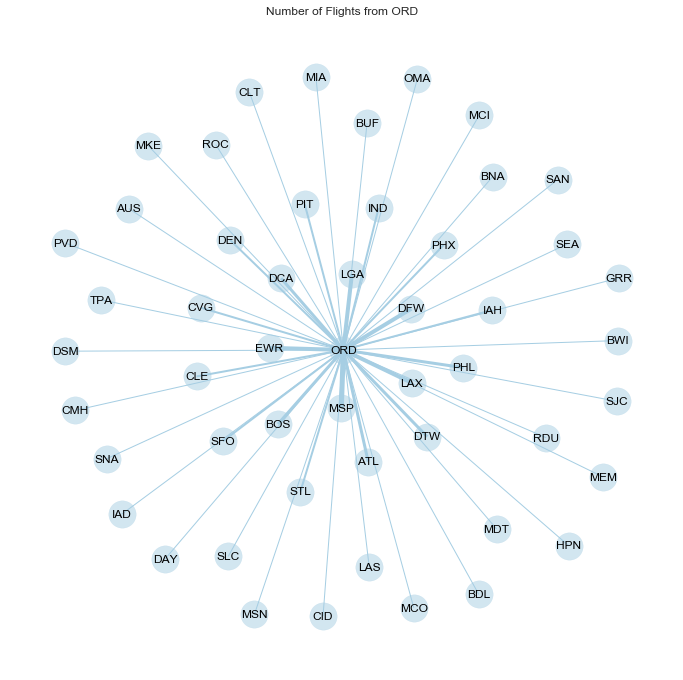

In [154]:
t_ax = draw_flights_graph(t_dg)

In [155]:
assert_is_instance(t_ax, mpl.axes.Axes)
assert_is_not(len(t_ax.title.get_text()), 0, msg="Your plot should have a title.")
assert_equal(t_ax.collections[0].get_offsets().shape[0], len(t_dg.nodes()))
assert_equal(len(t_ax.collections[1].get_segments()), len(t_dg.edges()))
assert_array_equal(np.sort(t_ax.collections[1].get_linewidth()), [1]*31+[2]*9+[3]*5+[4]*4+[5])

## Common Movie Interests between 30 Users

In [81]:
filename2 = 'Downloads/ml-latest-small/ratings.csv'
movies = pd.read_csv(filename2, header=0, usecols=(0, 1, 2)).dropna()

# name the selected dataframe as 'good_movies'
good_movies = movies[(movies['rating']>=4.0)&(movies['userId'].isin(np.arange(1, 31)))][['userId', 'movieId']]
print(good_movies.head(10))

    userId  movieId
4        1     1172
12       1     1953
13       1     2105
20       2       10
21       2       17
22       2       39
23       2       47
24       2       50
27       2      110
29       2      150


### get_top_pairs

In [110]:
def get_top_pairs(df=good_movies, n=100):
    '''
    Counts the number of common movie interests for any combination
    of two users in df, and returns top n paired users.
    
    Paramters
    ---------
    df: A pandas.DataFrame instance with two columns: 
        'userId' and 'movieId'. Default: good_movies.
    n: Number of destinations selected. Default: 100.
    
    Returns
    -------
    A list of tuples (paired users, count/number of occurrence) 
    in the form of (tuple, int), 
    i.e. a list of tuples((user1, user2), count/number of occurrence)
    in the form of ((int, int), int).
    '''
    
    result=[]
    for i,j in combinations(new.userId,2):
        s1=df.loc[df['userId']==i]
        s2=df.loc[df['userId']==j]
        result.append(((i,j),Counter(s1.movieId.isin(s2.movieId))[True]))
    result.sort(key=lambda tup: tup[1], reverse=True)    
    return result[:n]

In [111]:
top_10_pairs = get_top_pairs(n=10)
print('{0:20} {1:}'.format('Paired Users', 'Count'))
print('--'*15)
for paired_users, count in top_10_pairs:
    print('{0:3},{1:3} {2:16}'.format(paired_users[0], paired_users[1], count))

Paired Users         Count
------------------------------
 15, 30              125
 23, 30              111
 15, 23               92
 19, 30               86
  4, 30               82
 17, 23               79
 17, 30               72
 19, 23               69
 15, 17               67
 15, 19               66


### create_interests_graph

In [138]:
def create_interests_graph(top_pairs):
    '''
    Creates a graph of number of common movie interests count 
    between each user pair.
    
    Paramters
    ---------
    top_dests: A list of tuples (paired users, count/number of occurrence) 
               in the form of (tuple of (int, int), int).
    
    Returns
    -------
    A networkx.Graph instance.
    '''
    
    dg=nx.Graph()
    starts=[m[0][0] for m in top_pairs]
    ends=[n[0][1] for n in top_pairs]
    wts=[k[1] for k in top_pairs]
    min_weight = min(wts)
    norm_weights = [int(weight/min_weight) for weight in wts]
    edges=[j for j in zip(starts,ends,norm_weights)]
    dg.add_weighted_edges_from(edges)
    return dg

In [139]:
top_100_pairs = get_top_pairs(n=100)
p_dg = create_interests_graph(top_100_pairs)

In [156]:
assert_is_instance(p_dg, nx.Graph)
assert_equal(len(p_dg.nodes()), 25)
assert_equal(len(p_dg.edges()), len(top_100_pairs))

p100_u = [u for u, c in top_100_pairs]
p100_n = np.unique(np.ravel(p100_u))
p100_s = [set(u) for u, c in top_100_pairs]
p100_c = [c for u, c in top_100_pairs]
assert_equal(set(p_dg.nodes()), set(p100_n))

for start, end in p_dg.edges():
    assert_true(start in p100_n)
    assert_true(end in p100_n)
    assert_true(set((start, end)) in p100_s)

### draw_interests_graph

In [159]:
def draw_interests_graph(dg):
    '''
    Draws the Graph 'dg' with a circular layout.
    
    Paramters
    ---------
    dg: A networkx.Graph instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.despine(ax=ax, top = True, bottom = True, left = True, right = True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos=nx.circular_layout(dg)
    clrs = sns.color_palette("Paired")
    nx.draw_networkx_nodes(dg,pos,with_labels=True,node_size = 750,node_color=clrs[0],alpha = 0.5)
    weights = []
    for n1, n2, dct in dg.edges(data=True):
        weights.append(dct['weight'])
    nx.draw_networkx_edges(dg, pos, width = weights,edge_color=clrs.as_hex()[0],alpha=0.5)
    nx.draw_networkx_labels(dg, pos)
    plt.title('Common Movie Interests between 30 Users')
    return ax

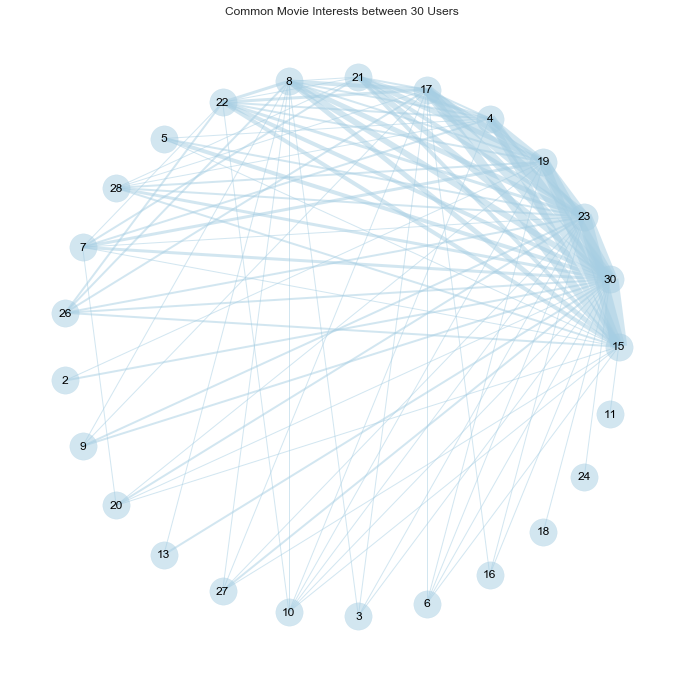

In [160]:
p_ax = draw_interests_graph(p_dg)

In [161]:
assert_is_instance(p_ax, mpl.axes.Axes)
assert_is_not(len(p_ax.title.get_text()), 0, msg="Your plot should have a title.")
assert_equal(p_ax.collections[0].get_offsets().shape[0], len(p_dg.nodes()))
assert_equal(len(p_ax.collections[1].get_segments()), len(p_dg.edges()))